In [1]:
from numpy.random import default_rng
import scanpy as sc
from anndata import AnnData
import scipy
sc.logging.print_header()
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import pandas as pd
from sklearn import metrics
import multiprocessing as mp
from sklearn.metrics.cluster import normalized_mutual_info_score
import pickle
import os.path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score

/home/vanhoan310/miniconda3/envs/gnn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.9.2 umap==0.5.7 numpy==1.24.4 scipy==1.8.1 pandas==1.4.2 scikit-learn==1.1.1 statsmodels==0.14.1 python-igraph==0.11.8 pynndescent==0.5.13


In [2]:
# scanpy==1.9.1 anndata==0.9.2 umap==0.5.7 numpy==1.24.4 scipy==1.8.1 pandas==1.4.2 scikit-learn==1.1.1 statsmodels==0.14.1
# python-igraph==0.11.8 pynndescent==0.5.13

## Read data

In [3]:
data_dir = 'Data/151673.h5ad'
adata=sc.read_h5ad(data_dir)
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Preprocessing data

In [4]:
n_features = adata.shape[1]
if n_features > 5000:
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
if n_features > 5000:
    adata =  adata[:, adata.var['highly_variable']]

In [5]:
## Perform PCA
sc.tl.pca(adata, n_comps=20)
# adata.obsm['X_pca'].shape
# if scipy.sparse.issparse(adata.X):
#     adata.obsm['X_feature'] = adata.X.todense() 
# else:
#     adata.obsm['X_feature'] = adata.X
# pca = PCA(n_components=20, random_state=42)
# adata.obsm['X_pca'] = pca.fit_transform(np.asarray(adata.obsm['X_feature']))

## Run GraphGB and visualization

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from utils import runGraphBG
n_clusters = 7
runGraphBG(adata, n_clusters=n_clusters, radius=50, key='X_pca', refinement=True, n_neighbors = 4, n_components = 20, covariance_type = 'tied', n_init = 5, max_iter = 1000)

tied ward
Data input shape n:  (3639, 20)


In [8]:
GraphBG_labels = adata.obs['domain'].values
GraphBG_labels

array([3, 5, 0, ..., 4, 0, 1])

<AxesSubplot:xlabel='x', ylabel='y'>

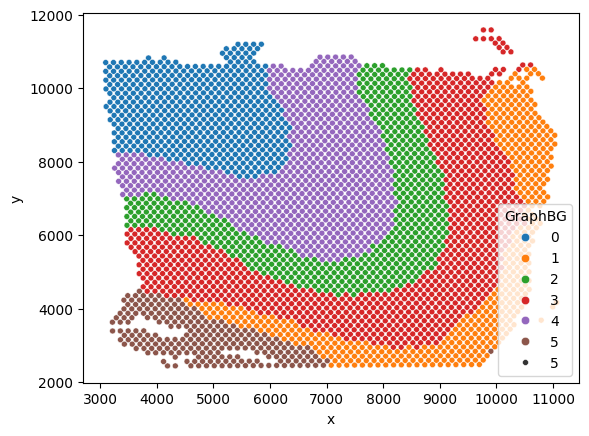

In [9]:
df_spatial = pd.DataFrame(adata.obsm['spatial'])
df_spatial['GraphBG'] = GraphBG_labels
df_spatial.columns = ['x', 'y','GraphBG']
sns.scatterplot(x="x", y="y", hue = 'GraphBG', size = 5, data=df_spatial, palette="tab10")

In [10]:
## Compute the NMI with ground truth
true_labels = pd.factorize(adata.obs['Region'])[0]
print(normalized_mutual_info_score(true_labels[true_labels>=0], GraphBG_labels[true_labels>=0]))

0.7464237519029667
